# The first step is -> Read the data
## We have already made this function 
## Read More: [Stock Markets](https://github.com/Masoud-Khosravi/Stock-Markets)

In [1]:
from ReadData import MetaTrader

In [2]:
my_obj = MetaTrader("XAUUSD", "M5",count=6000)
if my_obj:
    print("Everything is fine.")
else:
    print("Entered Symbol <{}> is {}".format(my_obj.symbol, my_obj._symbol_exist))
    print("and Entered Timeframe is {}".format(my_obj.time_frame))

Everything is fine.


In [3]:
df_raw=my_obj.df_type1_raw

In [4]:
import pandas as pd
import numpy as np

In [5]:
df_raw.tail()

,time,open,high,low,close,tick_volume,High9,High26,High52,Low9,Low26,Low52
5943,2022-12-23 20:30:00,1796.24,1796.34,1795.73,1795.99,245,1798.96,1803.19,1803.19,1795.65,1795.65,1791.14
5944,2022-12-23 20:35:00,1795.97,1796.03,1794.94,1795.33,319,1798.22,1803.19,1803.19,1794.94,1794.94,1791.14
5945,2022-12-23 20:40:00,1795.33,1795.33,1794.14,1794.42,340,1797.72,1803.19,1803.19,1794.14,1794.14,1791.14
5946,2022-12-23 20:45:00,1794.43,1795.52,1793.58,1795.18,423,1797.72,1802.85,1803.19,1793.58,1793.58,1791.14
5947,2022-12-23 20:50:00,1795.21,1795.79,1795.03,1795.71,259,1797.72,1802.18,1803.19,1793.58,1793.58,1791.14


# Now it's time to make y_values
## in this part we create the y values
### we calculate stop loss in each candles close price based on low26/high26
### <low26: for buy signals & high26: for sell signals>
### and we set take profit at least twice (means TP>=2*SL)        
### Then we give time to the program: in this section time is equal to 24 candles
### Means: this model must take profit before reaching the stop loss in maximum 24 candles
###  So 
+ if it is profitable in sell means our signal should be 'Sell'
+ if it is profitable in buy means our signal should be 'Buy'
+ if the model does not take profit in any of them before reaching the stop loss
--> our signal is 'Nothing' in that candles close time
## we show:
+ buy signals by->1
+ sell signals by->2
+ and Do Nothings by->0

## lets go  

In [6]:
def create_y(dataframe):
    """
    Please pass your raw dataframe
    exp:
  
    """
    df=dataframe.copy()
    #create an empty y values
    y=pd.DataFrame(np.nan,index=np.arange(len(df)),columns=["y_true"])
    
    # in this part from time the only thing that matters to us is the hour
    df['time'] = df['time'].apply(lambda num: num.hour)
    for pos in np.arange(0, len(df)):
        close_price = df.loc[pos, 'close']
        # calculate distance of stop loss and create tp points
        sl_buy = close_price-df.loc[pos, 'Low26']
        sl_sell = df.loc[pos, 'High26']- close_price
        
        tp_buy = sl_buy * 2.1
        tp_sell = sl_sell * 2.1
        signal = 0 # default signal is Zero (do nothing)        
        # we don't trade after 11 p.m until 4 a.m menas in this hour signals should be Zero
        if (df.loc[pos, 'time'] < 23) and (df.loc[pos, 'time'] > 4):
            for last in np.arange(1, 25):# This is the part where we give maximum time to the model: 24 candles
                if (pos + last) < len(df):
                    high_last = df.loc[pos + last, 'High26']- close_price
                    low_last = close_price- df.loc[pos + last, 'Low26']
                    low_now = close_price- df.loc[pos + last, 'low']
                    high_now = df.loc[pos + last, 'high']- close_price
                    if (low_last <= sl_buy) and (high_now > tp_buy):
                        signal = 1
                        break
                    elif (high_last <= sl_sell) and (low_now > tp_sell):
                        signal = 2
                        break
        y.loc[pos] = signal
    # End of for pos in np.arrange(0,len(df)):
    # df = df.iloc[:-26, :]
    return y

In [7]:
y=create_y(df_raw)

In [8]:
y.value_counts()

y_true
0.0       4513
1.0        741
2.0        694
dtype: int64

In [9]:
from Learnings import Classifications

## After we create y we pass normalized dataframe to models
### So we have normalized df:

In [10]:
df=my_obj.df_type1_changed
# change the shape of y
y=pd.to_numeric(y['y_true'], downcast='integer')
Class_obj=Classifications(df,y)

# Let's check the models:

Accuracy:  0.7361344537815127
B_Accuracy:  0.4216319648520697
final_score= -7


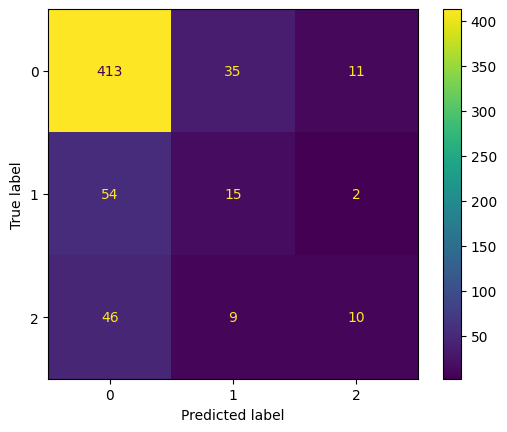

In [11]:
model=Class_obj.ada_boost()
Class_obj.evaluates.plot_confusion_matrix()

Accuracy:  0.7512605042016807
B_Accuracy:  0.5907447140808091
final_score= 37


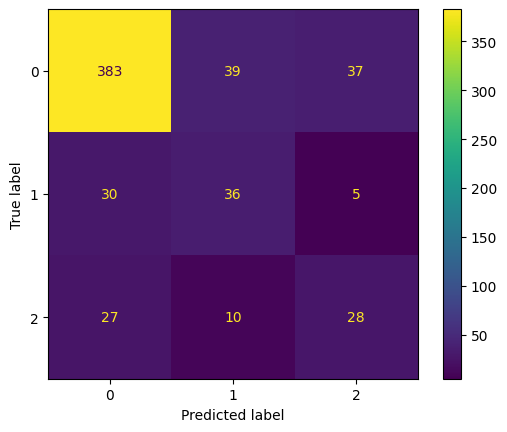

In [12]:
model=Class_obj.decision_trees()
Class_obj.evaluates.plot_confusion_matrix()

Accuracy:  0.7747899159663866
B_Accuracy:  0.509701794926871
final_score= 36


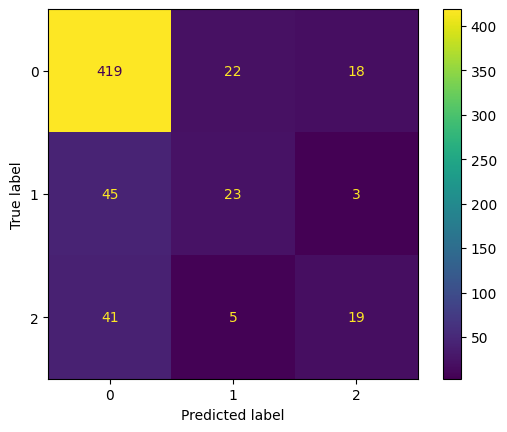

In [13]:
model=Class_obj.k_nearest_neighbors()
Class_obj.evaluates.plot_confusion_matrix()

[LibSVM]Accuracy:  0.773109243697479
B_Accuracy:  0.3380281690140845
final_score= 2


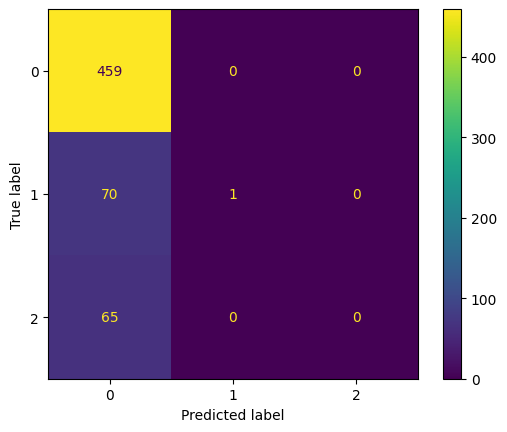

In [14]:
model=Class_obj.support_vector_machine()
Class_obj.evaluates.plot_confusion_matrix()

19/19 [==============================] - 0s 722us/step
Accuracy:  0.7109243697478992
B_Accuracy:  0.5032487759358789
final_score= -5


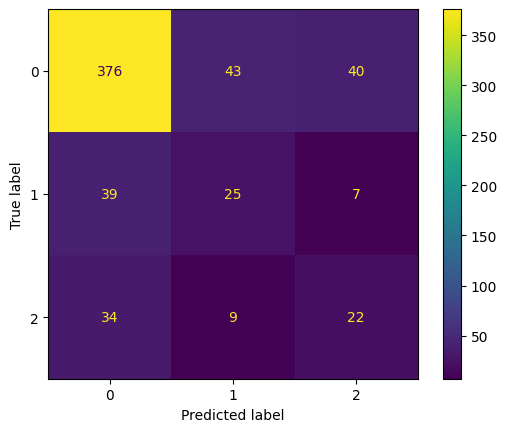

In [15]:
model=Class_obj.tensorflow()
Class_obj.evaluates.plot_confusion_matrix()

Accuracy:  0.8201680672268907
B_Accuracy:  0.5456174845846208
final_score= 69


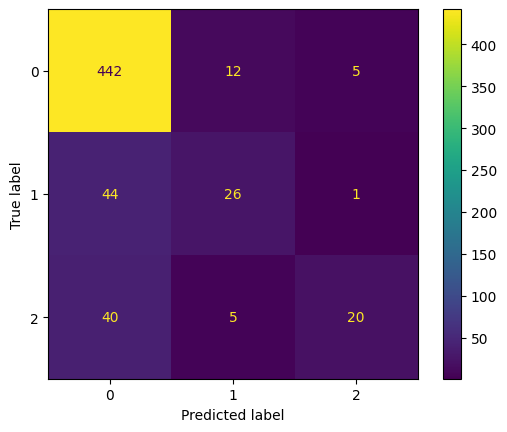

In [16]:
model=Class_obj.random_forest()
Class_obj.evaluates.plot_confusion_matrix()

# As you can see we have one new row in evaluation
# yes that is <Final Score> So What is it ?
# as you know 
+ when our model predict 0 mean no signal --> We don't lose money AND We don't earn money
+ when our model predict 1 or 2 --> We have Buy/Sell signal 
    + if we loss --> we lose money by stop loss (SL)
    + if we won --> we earn money by take profit (TP>2*SL)

# So --> How Calculate final Score ?
+ 0-> No Signal -> No Point
+ 1/2 (Buy/Sell) if it was True --> We GET 2 Point (2*SL)
+ 1/2 (Buy/Sell) if it was False --> We LOSE 1 point (SL)
    + Final Score= True Signals*2 - False Signal

# Now After Evaluating models we could use one of theme to get signal of last candle
## for  example our last model is RandomForest
## so after we got last candle data we can predict from model
# lets go

In [17]:
# updating Last candle data
if my_obj.update_last():
    print('Everything good')

Everything good


In [18]:
last_candle=my_obj.df_last_candle_type1_changed
last_candle

,time,open,high,low,tick_volume,High9,High26,High52,Low9,Low26,Low52
0,1.301292,0.567021,0.795135,0.154405,-0.7552,-0.137696,-1.098955,-0.688653,0.137427,-0.342643,-0.072697


In [19]:
last_signal=model.predict(last_candle)
last_signal

array([0], dtype=int8)

In [20]:
if last_signal[0]==1:
    print("last signal is: Buy")
elif last_signal[0]==2:
    print("last signal is: Sell")
else:    
    print("last signal is: Do Nothing")

last signal is: Do Nothing
